In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [34]:
class MNISTDataset(Dataset):
    def __init__(self, root_dir, tsv_file=None, transform=None):
        self.transform = transform
        self.samples = []
        if tsv_file:
            with open(tsv_file, 'r') as f:
                for line in f:
                    path, label = line.strip().split('\t')
                    self.samples.append((os.path.join(root_dir, path), int(label)))
        else:
            for label in sorted(os.listdir(root_dir)):
                label_dir = os.path.join(root_dir, label)
                if os.path.isdir(label_dir):
                    for img_name in os.listdir(label_dir):
                        self.samples.append((os.path.join(label_dir, img_name), int(label)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        image = image.view(-1)
        return image, label

In [35]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [36]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(train_loader.dataset)

In [37]:
def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [44]:
def hyperparameter_search(train_dataset, val_dataset, device):
    hidden_sizes = [10, 32, 64, 128, 256]
    learning_rates = [0.0001, 0.001, 0.01, 0.1]
    best_val_acc = 0.0
    results = {}
    best_params = None
    best_model = None

    for hs in hidden_sizes:
        for lr in learning_rates:
            model = MLP(28*28, hs, 10).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
            train_losses = []
            val_accuracies = []
            
            for epoch in range(5):
                train_loss = train_model(model, train_loader, criterion, optimizer, device)
                train_losses.append(train_loss)
                val_acc = evaluate_model(model, val_loader, device)
                val_accuracies.append(val_acc)

            results[(hs, lr)] = (train_losses, val_accuracies)

            print(f"Hidden Size: {hs}, LR: {lr}, Val Accuracy: {val_acc:.4f}")
            if val_accuracies[-1] > best_val_acc:
                best_val_acc = val_accuracies[-1]
                best_params = (hs, lr)
                best_model = model

    print("Best Hyperparameters:", best_params, "with validation accuracy:", best_val_acc)
    return best_model, best_params, results

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.view(-1))
    ])

In [47]:
train_data_path = '/Users/user/Downloads/MNIST-full/train'
train_tsv = '/Users/user/Downloads/MNIST-full/gt-train.tsv'
full_train_dataset = MNISTDataset(root_dir='/Users/user/Downloads/MNIST-full/', tsv_file='/Users/user/Downloads/MNIST-full/gt-train.tsv', transform=transform)

# Split into training and validation sets
indices = list(range(len(full_train_dataset)))
train_indices, val_indices = train_test_split(indices, test_size=0.1, random_state=42)
train_subset = torch.utils.data.Subset(full_train_dataset, train_indices)
val_subset = torch.utils.data.Subset(full_train_dataset, val_indices)


In [48]:
best_model, best_params, results = hyperparameter_search(train_subset, val_subset, device)

Hidden Size: 10, LR: 0.0001, Val Accuracy: 0.8965
Hidden Size: 10, LR: 0.001, Val Accuracy: 0.9157
Hidden Size: 10, LR: 0.01, Val Accuracy: 0.9023
Hidden Size: 10, LR: 0.1, Val Accuracy: 0.1473
Hidden Size: 32, LR: 0.0001, Val Accuracy: 0.9218
Hidden Size: 32, LR: 0.001, Val Accuracy: 0.9607
Hidden Size: 32, LR: 0.01, Val Accuracy: 0.9342
Hidden Size: 32, LR: 0.1, Val Accuracy: 0.0957
Hidden Size: 64, LR: 0.0001, Val Accuracy: 0.9332
Hidden Size: 64, LR: 0.001, Val Accuracy: 0.9677
Hidden Size: 64, LR: 0.01, Val Accuracy: 0.9497
Hidden Size: 64, LR: 0.1, Val Accuracy: 0.1527
Hidden Size: 128, LR: 0.0001, Val Accuracy: 0.9458
Hidden Size: 128, LR: 0.001, Val Accuracy: 0.9733
Hidden Size: 128, LR: 0.01, Val Accuracy: 0.9397
Hidden Size: 128, LR: 0.1, Val Accuracy: 0.1597
Hidden Size: 256, LR: 0.0001, Val Accuracy: 0.9588
Hidden Size: 256, LR: 0.001, Val Accuracy: 0.9750
Hidden Size: 256, LR: 0.01, Val Accuracy: 0.9507
Hidden Size: 256, LR: 0.1, Val Accuracy: 0.1133
Best Hyperparameters: 

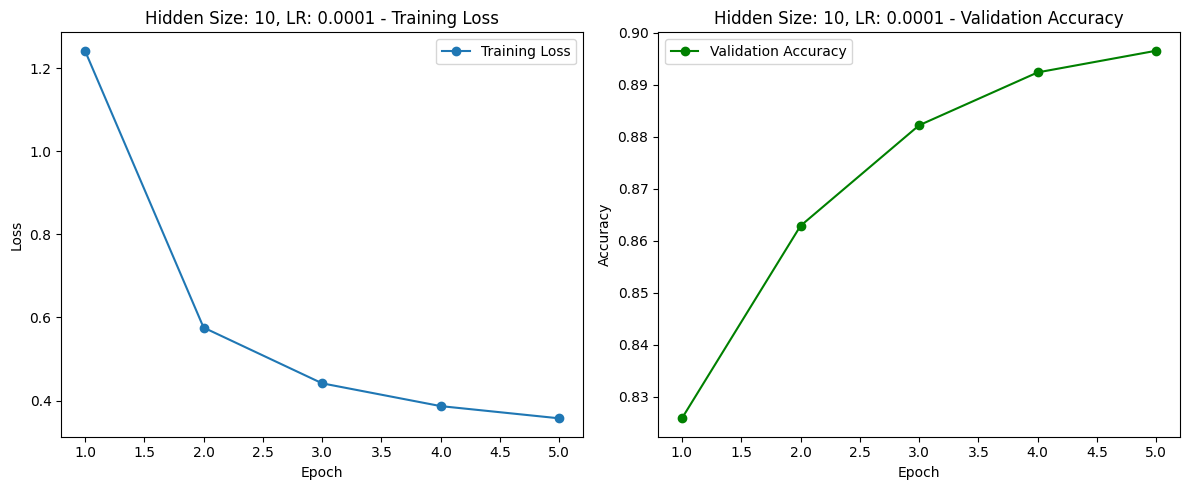

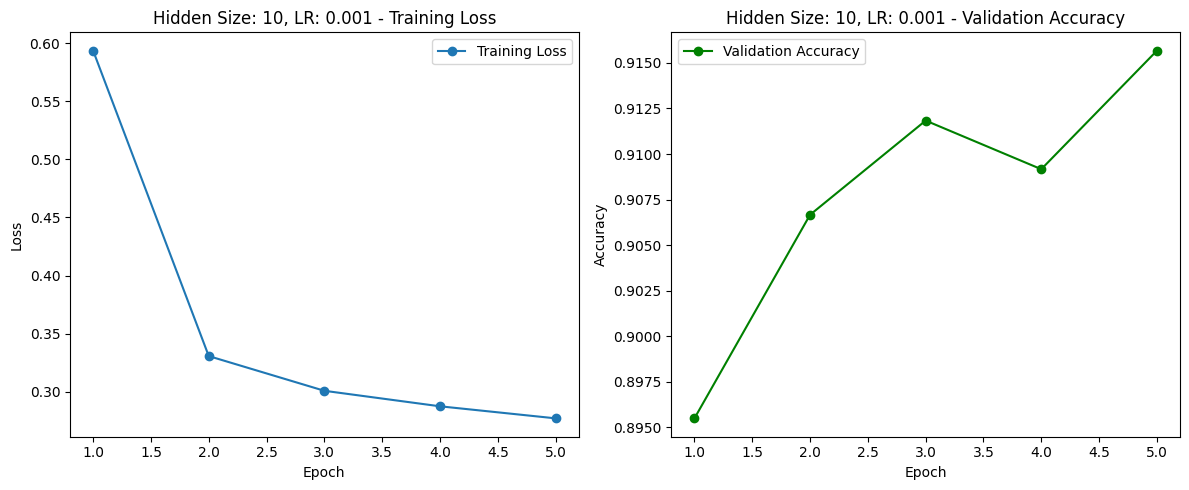

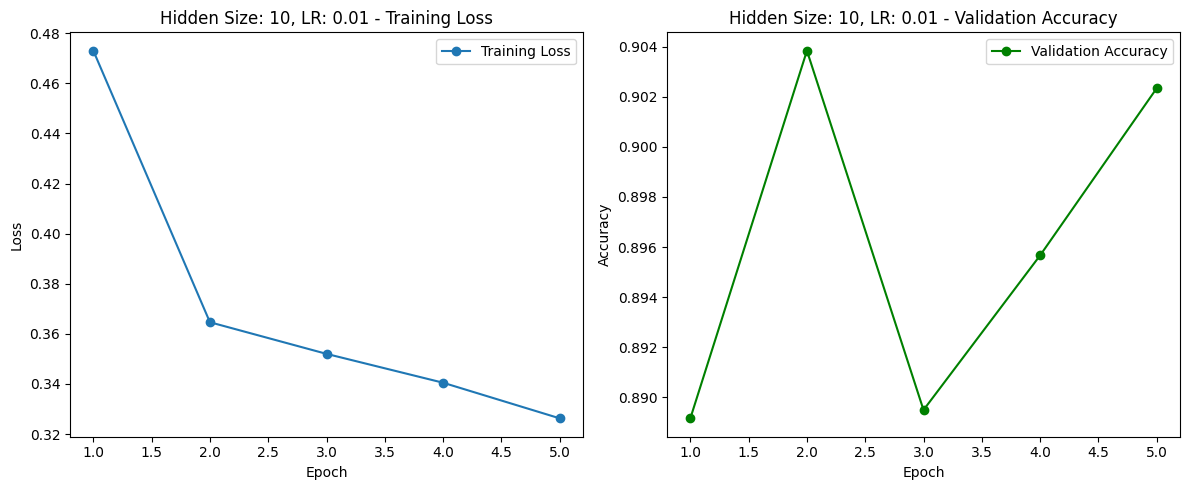

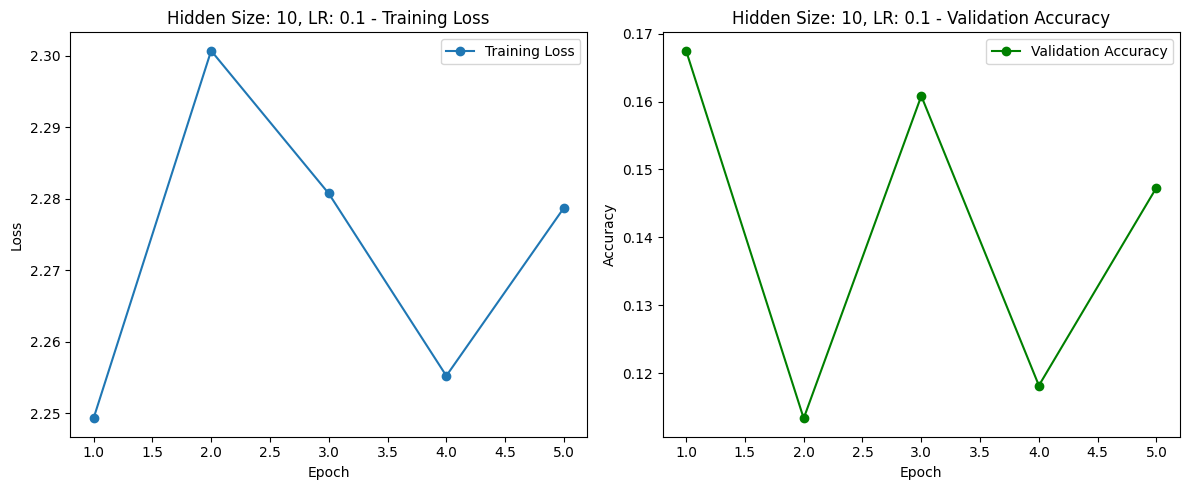

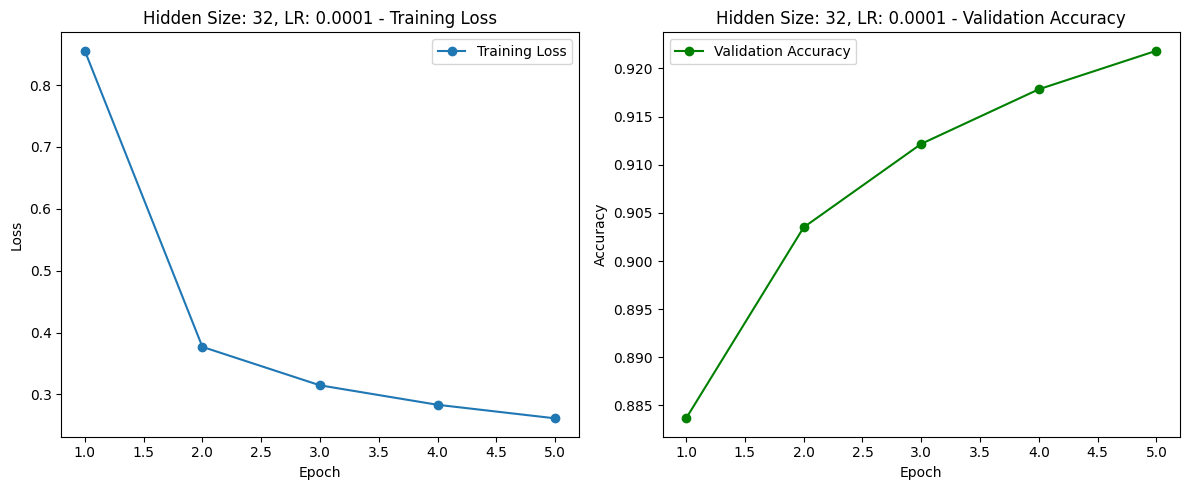

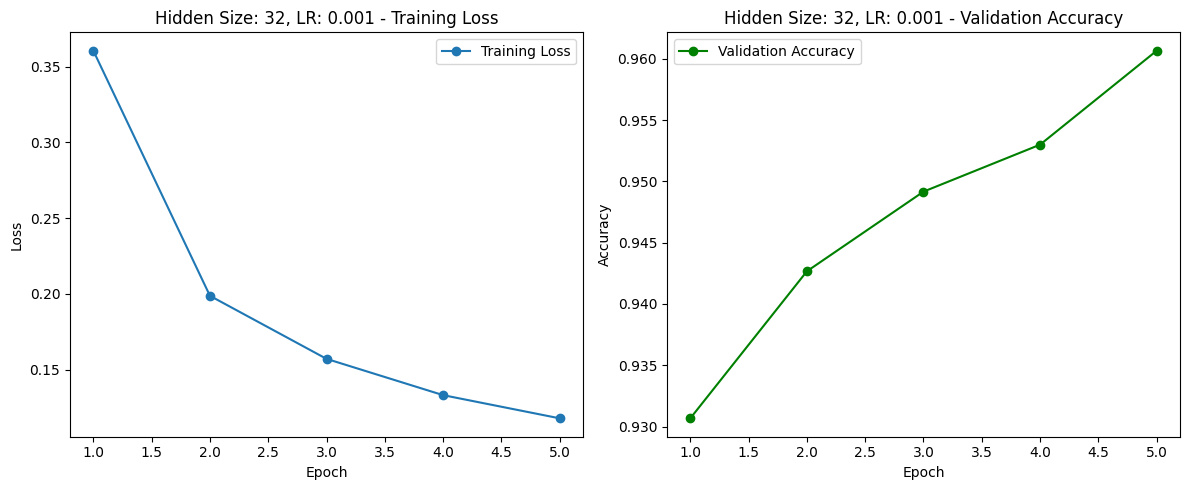

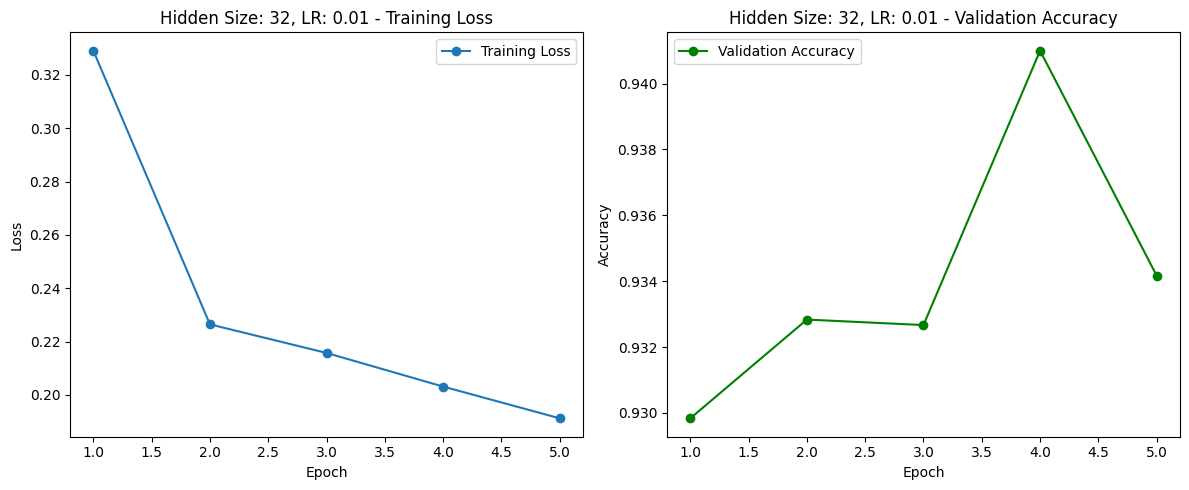

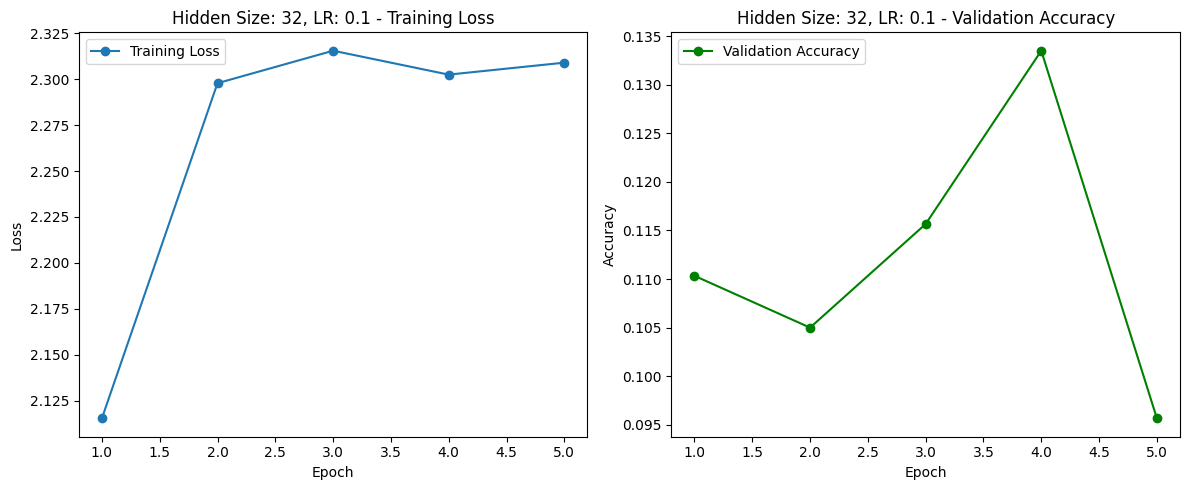

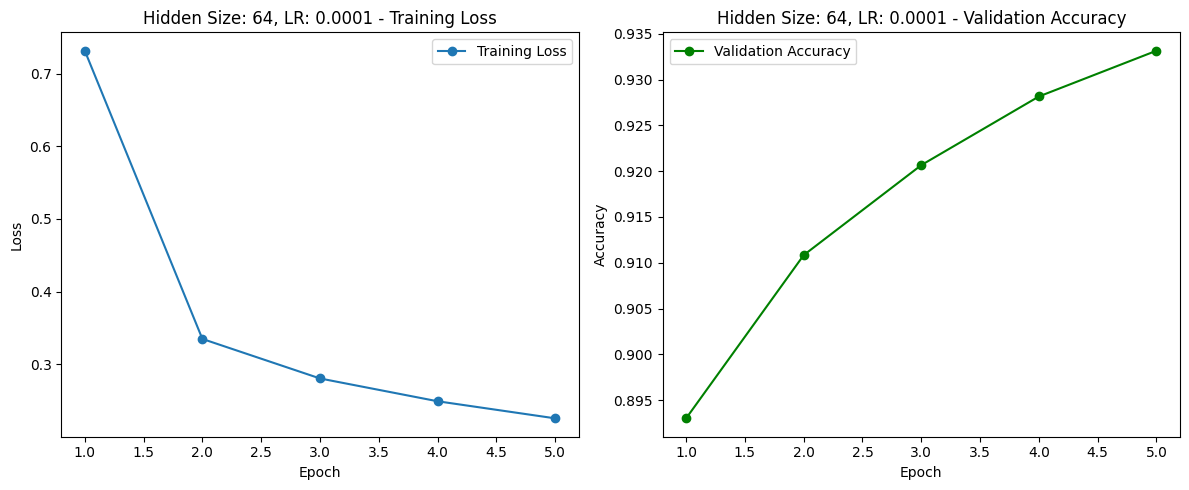

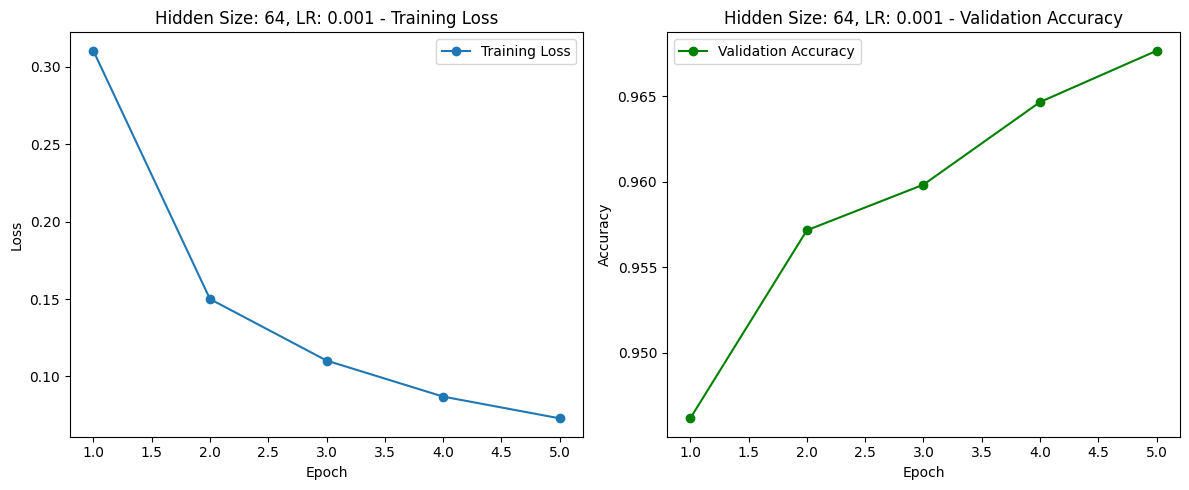

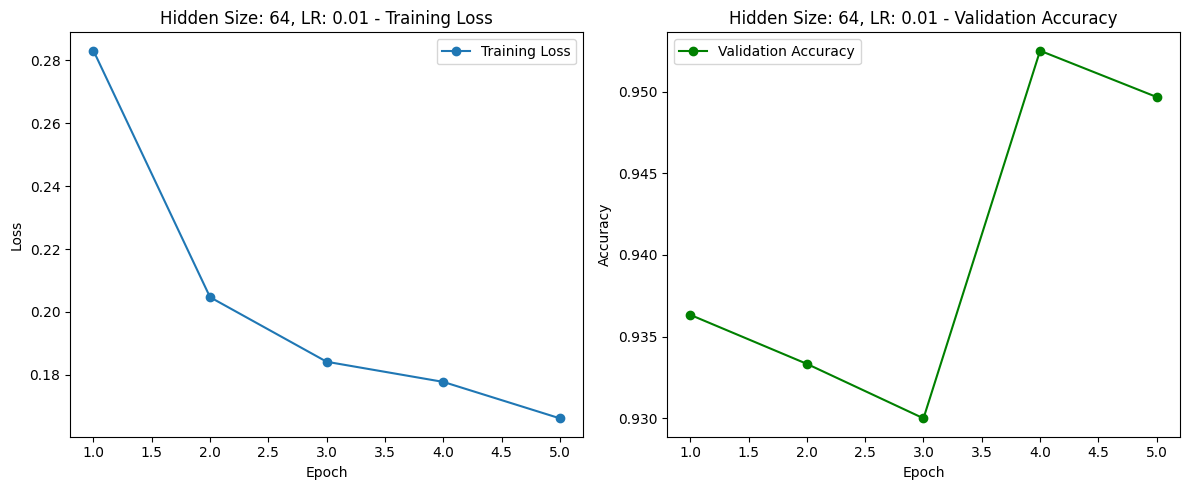

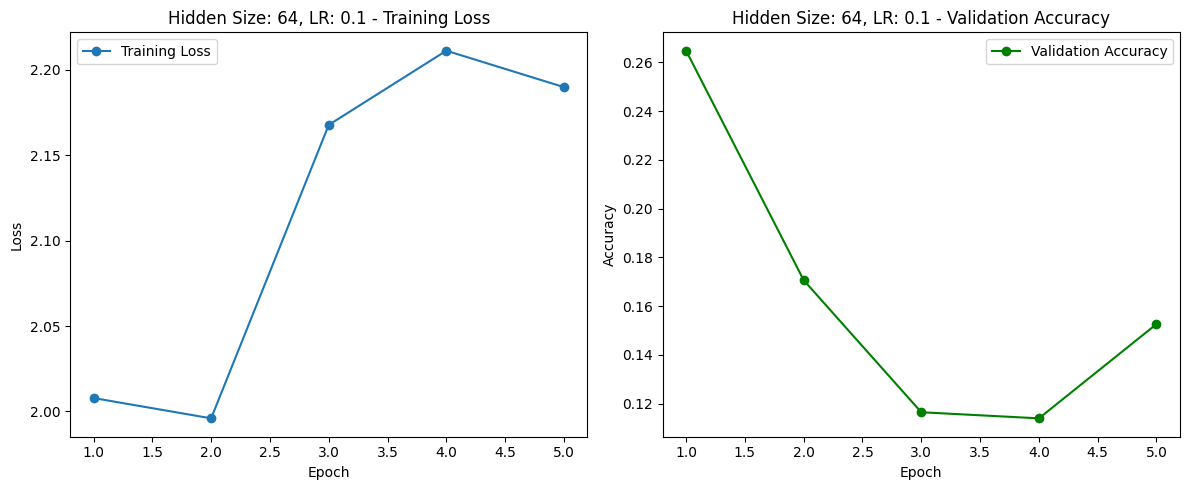

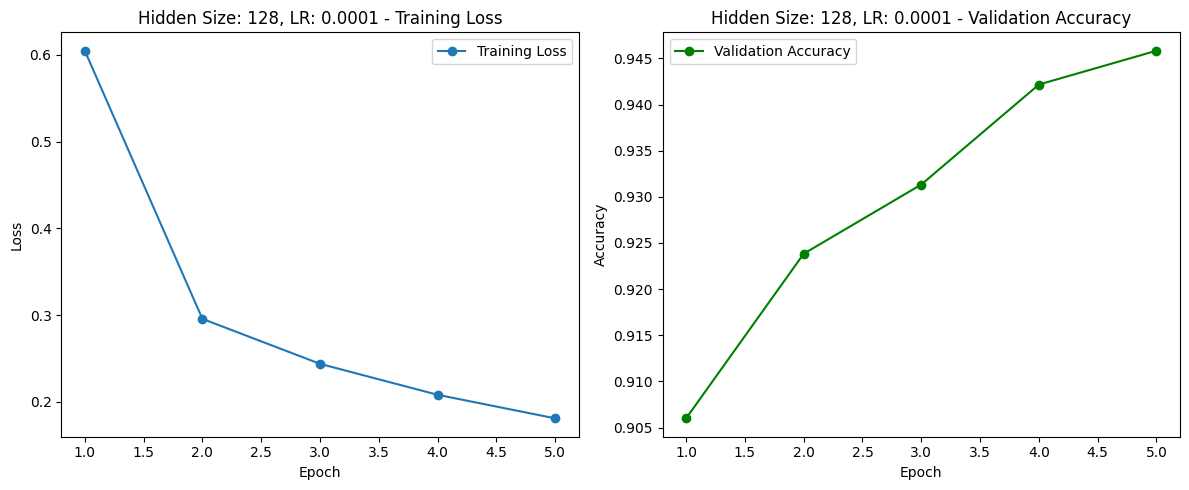

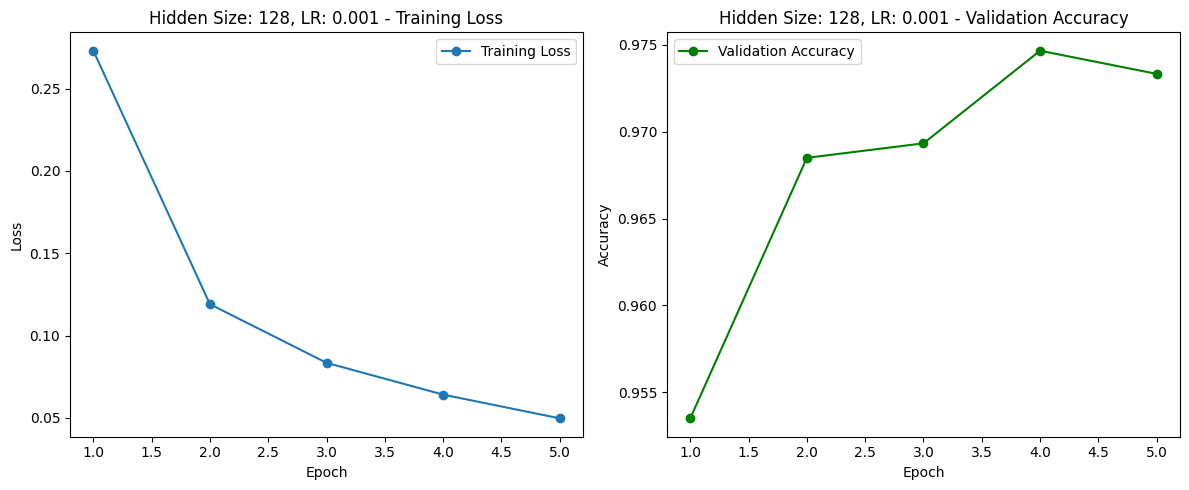

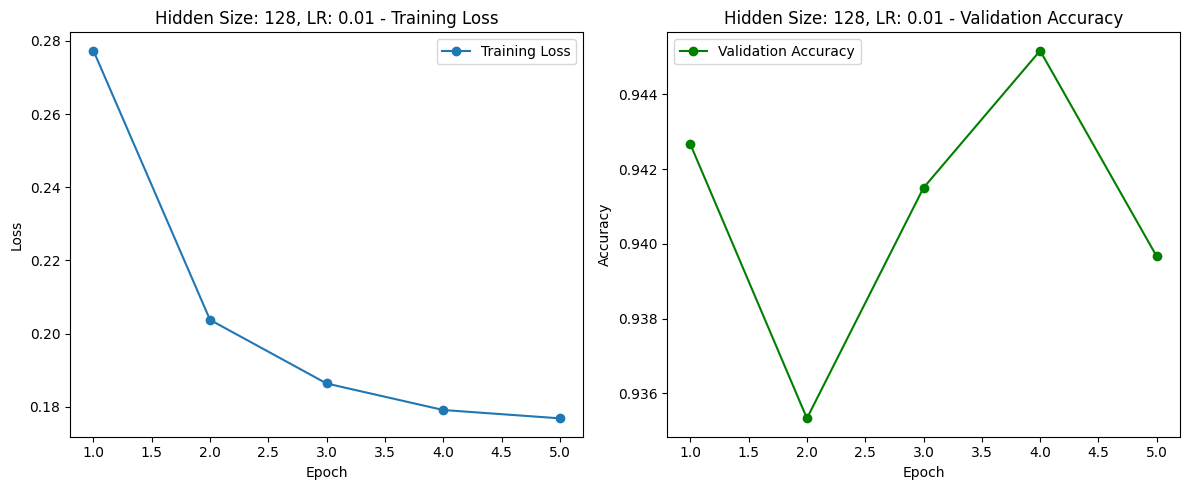

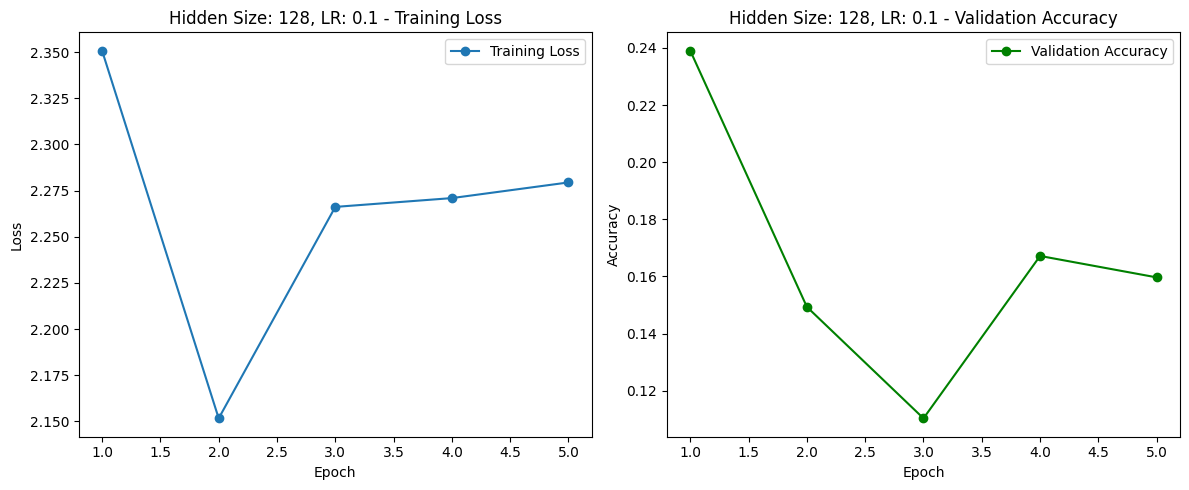

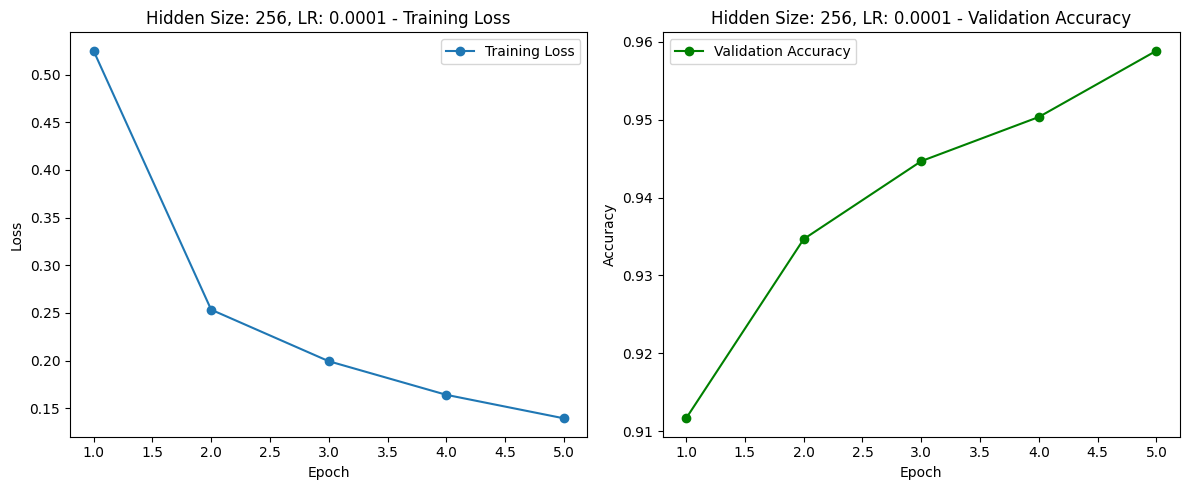

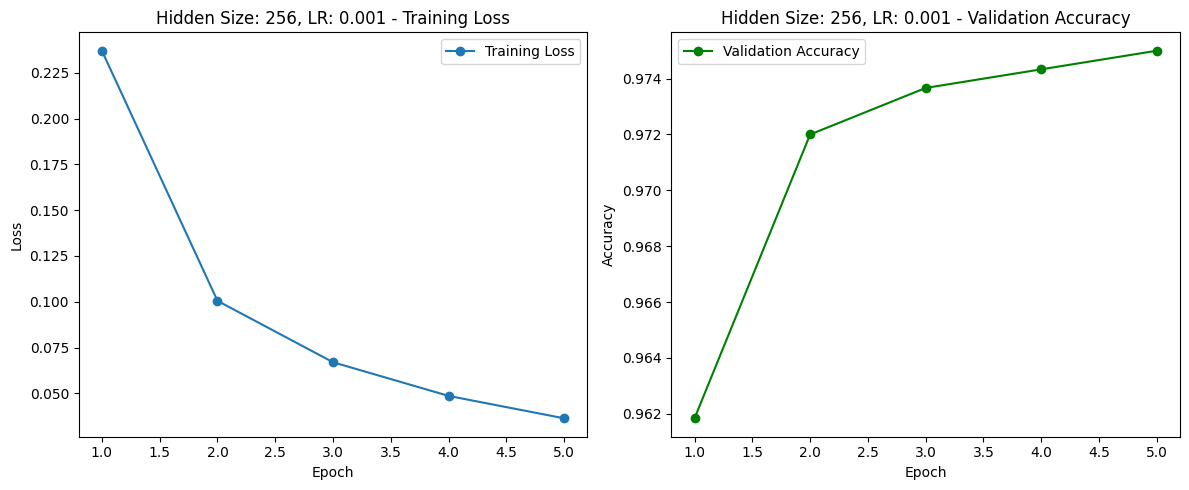

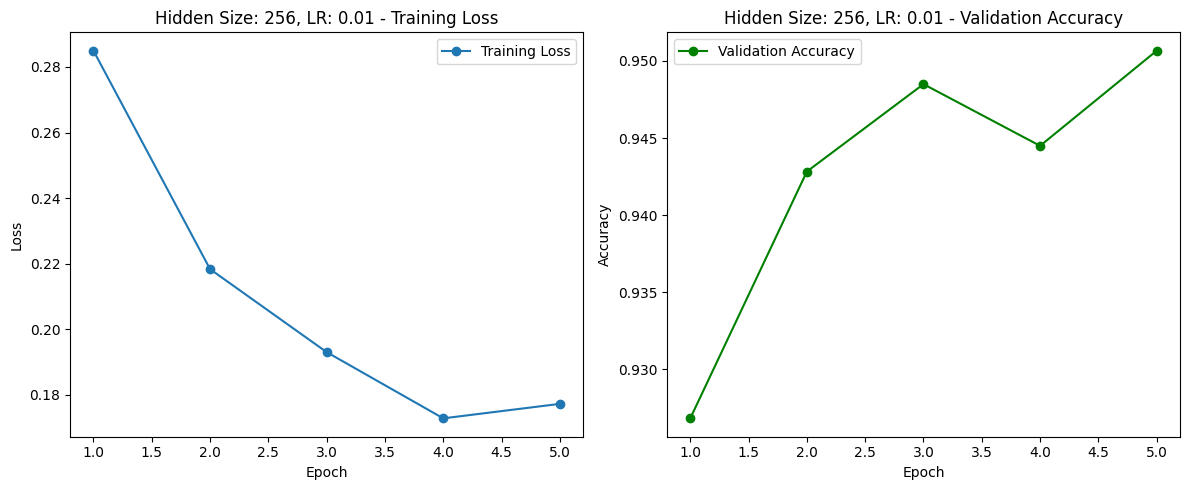

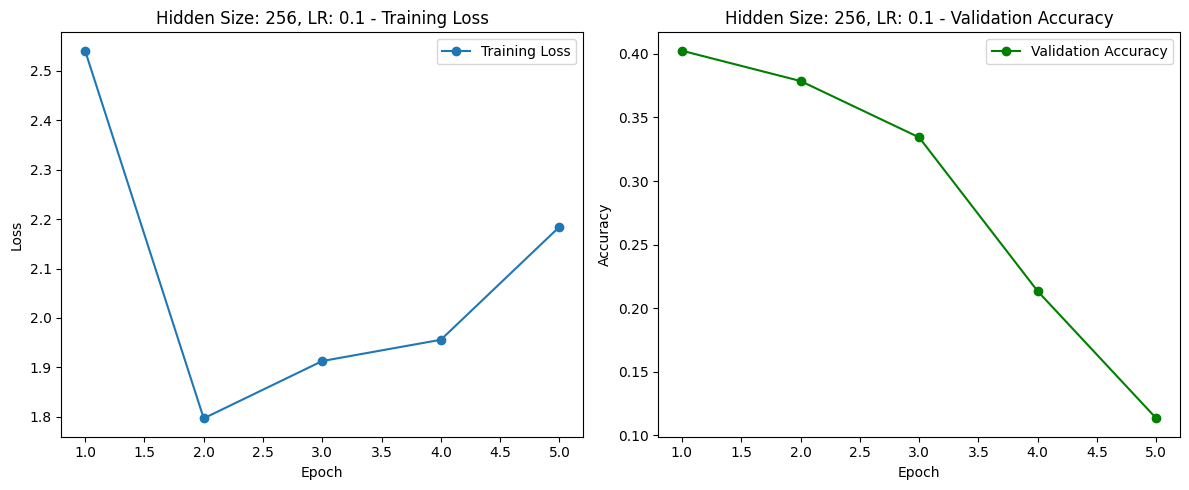

In [ ]:
for key, (train_losses, val_accuracies) in results.items():
    hs, lr = key
    epochs = range(1, len(train_losses)+1)

    plt.figure(figsize=(12, 5))
        
     # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', label="Training Loss")
    plt.title(f"Hidden Size: {hs}, LR: {lr} - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, marker='o', color='green', label="Validation Accuracy")
    plt.title(f"Hidden Size: {hs}, LR: {lr} - Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
        
    plt.tight_layout()
    plt.show()

In [58]:
test_dataset = MNISTDataset(root_dir='/Users/user/Downloads/MNIST-full/', tsv_file='/Users/user/Downloads/MNIST-full/gt-test.tsv', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_acc = evaluate_model(best_model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9759
